# Modified Himmelblau function

The Himmelblau function $(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2}$ is a multi modal objective function with four minima. Here we modify it so that $(3,2)$ is the global minimum, while the other three global minima become local minima. Our modified Himmelblau function is then given as:

$(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2} + (x-3)^2+(y-2)^2$

Thus, depending on the starting model an optimiser can get stuck in one of the three local minima and not reach the global minimum. In comparison global search methods such as Border Collie Optimisation can potentially find the global minimum.

## Further reading
- T. Dutta, S. Bhattacharyya, S. Dey and J. Platos, "Border Collie Optimization," in IEEE Access, vol. 8, pp. 109177-109197, 2020, doi: 10.1109/ACCESS.2020.2999540


# Analytical solution
We first use sympy https://www.sympy.org/ to find the minimum of our modfified Himmelblau function.

In [10]:
import sympy

x,y =sympy.symbols("x y")
f=(x**2+y-11.0)**2+(x+y**2-7.0)**2+(x-3.0)**2+(y-2.0)**2
gradient = sympy.derive_by_array(f, (x,y))
stationary_points = sympy.solve(gradient, (x,y))
print(stationary_points)

[(3.00000000000000, 2.00000000000000)]


# Objective function

We begin by loading all the required modules and then plot the obejctive function

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation

import arviz as az

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.utils import QuadraticReg

np.random.seed(42)

In [12]:
def modified_himmelblau(x): 
    return (x[0]**2+x[1]-11)**2+(x[0]+x[1]**2-7)**2+((x[0]-3)**2+(x[1]-2)**2)

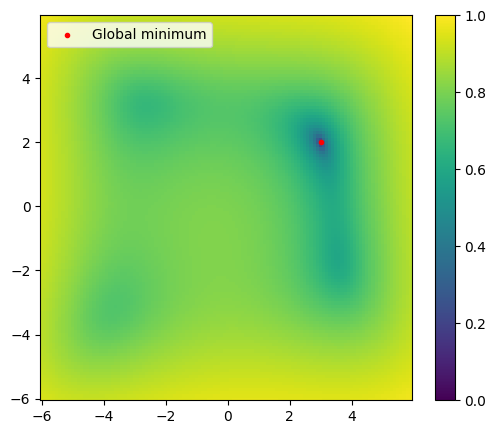

In [13]:
# Initialize figure 
fig = plt.figure(figsize=(6, 5))
ax = fig.gca()

# Evaluate function
X = np.arange(-6, 6, 0.1)
Y = np.arange(-6, 6, 0.1)
X, Y = np.meshgrid(X, Y)
Z = modified_himmelblau([X,Y])
im = ax.pcolor(X,Y,Z, norm=colors.LogNorm(vmin=10**-2, vmax=Z.max()))
im = ax.scatter(3,2,color='red',label="Global minimum", marker='.')
ax.legend(loc='upper left')
fig.colorbar(im)

## BFGS
Use BFGS and  $(-1,-1)$ as the intial model which will result in a local minimum being found.

In [14]:
# Define the Base Problem
inv_problem = BaseProblem()
inv_problem.name = "Modfified Himmelblau Function"
inv_problem.set_objective(modified_himmelblau)
inv_problem.set_model_shape((2))
inv_problem.set_initial_model([-1,-1])

In [15]:
# Define the inverse options
inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.minimize")

# Run the inversion
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 71.84222128219835
jac: [-9.53674316e-06  2.86102295e-06]
hess_inv: [[0.01084335 0.00361916]
 [0.00361916 0.01428301]]
nfev: 48
njev: 16
status: 0
message: Optimization terminated successfully.
nit: 10
model: [-3.61235325 -3.10165561]


## Border collie optimisation

Use CofI's implementation of Border Collie optimisation which gets us into the vicinity of the global minimum.

In [16]:
inv_problem = BaseProblem()
inv_problem.name = "Modified Himmelblau Function"
inv_problem.set_objective(modified_himmelblau)
inv_problem.set_model_shape((2))

In [17]:
# Define the inverse options
bounds= ((-6.0,6.0),(-6.0,6.0))

inv_problem.set_bounds(bounds)

inv_options = InversionOptions()
inv_options.set_params(number_of_iterations=100)
inv_options.set_tool("cofi.border_collie_optimization")

# Run the inversion
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [18]:
inv_result.model

array([3.0183142 , 2.04202664])

Next we plot the states of the flock of sheep and the pack of dogs. We can observe how the lead dog goes to a minimum (i.e. the farm) and once it has arrived there it runs away to gather more sheep. Similarly the sheep get herded towards the global minimum.

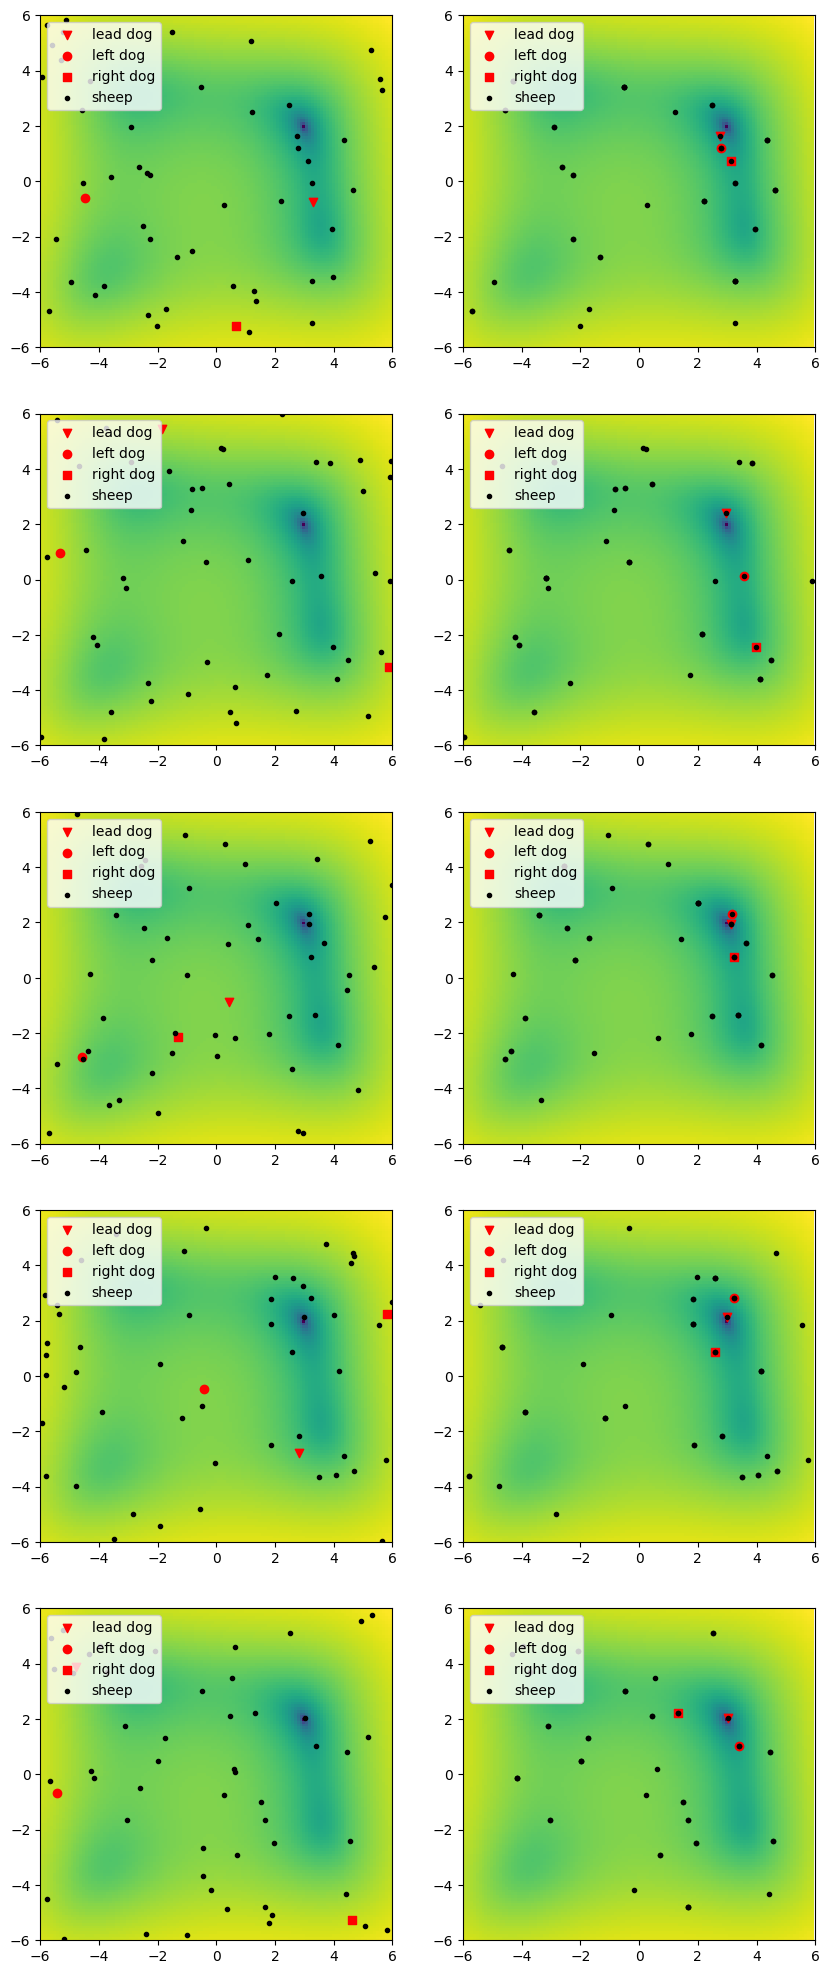

In [22]:
n=len(inv_result.pack_position_history)
fig, ax = plt.subplots(n//2, 2)
fig.set_size_inches(10,5*n//2)
dmarkers=["v","o","s"]
dlabels=["lead dog","left dog","right dog"]
for i in range(n):
    ax[i//2,i%2].pcolor(X,Y,Z,norm=colors.LogNorm(vmin=10**-2, vmax=Z.max()))
    # Plot that point using the x and y coordinates
    pack=inv_result.pack_position_history[i]
    flock=inv_result.flock_position_history[i]
    dmarkers
    for j,dog in enumerate(pack):
        ax[i//2,i%2].scatter(dog[0],dog[1], color='red', label=dlabels[j], marker=dmarkers[j])
    for j,sheep in enumerate(flock):
        if j==0:
            ax[i//2,i%2].scatter(sheep[0],sheep[1], label="sheep",color='black', marker='.')
        else:
            ax[i//2,i%2].scatter(sheep[0],sheep[1], color='black', marker='.')

    # Set the x and y axis to display a fixed range.
    ax[i//2,i%2].set_xlim([-6, 6])
    ax[i//2,i%2].set_ylim([-6, 6])
    ax[i//2,i%2].legend(loc='upper left')